In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import sys
import os
import re
import pickle
import seaborn as sns
import datetime as dt

import xgboost

sys.path.insert(0, r'C:\Users\Y893263\Python_snowflake')
import snowflake_connect
import sqlite_connect

import warnings
warnings.simplefilter('ignore')


pd.options.display.float_format = '{:,.2f}'.format

In [2]:
import statsmodels.api as sm
from random import gauss
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from random import random
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

In [3]:
# general settings
class CFG:
    data_folder = os.getcwd() + '\\'
    img_dim1 = 20
    img_dim2 = 10
        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)}) 

In [6]:


sql_query = """
SELECT 
  EXTRACT (YEAR FROM gl.DOC_POST_DT) AS sap_post_year,
  gl.FISCL_YR_MO_NBR AS fiscal_year,
  gl.BUS_AREA_CD as bus_area,
  gl.CMPY_CD as company_code,
  coa.COST_CNTR_WO_ZEROS_CD AS cost_center,
  coa.COST_CNTR_NM cost_center_name,
  coa.COST_ELEM_WO_ZEROS_CD AS cost_element,
  coa.COST_ELEM_NM AS cost_element_name,
  gl.LCL_CRNCY_DBT_CR_AMT AS amount,
  gl.ACCTG_DOC_TYP_CD AS doc_type,
  gl.ORD_NBR AS Internal_order, 
  gl.DOC_POST_DT as post_date
FROM FACTS.FINANCIALS.GL_LN_ITEM gl
JOIN ABI_WH.EDW.COA_RPT_XREF coa
ON (gl.COST_CNTR_CD = coa.COST_CNTR_CD AND gl.GL_ACCT_NBR = coa.COST_ELEM_CD)
WHERE cost_element IN ('870008', '870009', '870040')
AND (cost_center = '1220000053')
AND (gl.FISCL_YR_MO_NBR BETWEEN 2020001 AND to_number(to_char(current_date, 'YYYYMMDD')))

;
"""

In [7]:
df = snowflake_connect.snowflake_connection(sql_query=sql_query)
df = df.rename(columns=str.lower)

opening...


In [8]:
df['post_date'] = pd.to_datetime(df['post_date'])
df = df.set_index('post_date')
# df['ts_m'] = df['POST_DATE'].to_period('D')

In [9]:
df

,sap_post_year,fiscal_year,bus_area,company_code,cost_center,cost_center_name,cost_element,cost_element_name,amount,doc_type,internal_order
post_date,,,,,,,,,,,
2020-06-22,2020,2020006,1111,1100,1220000053,MERCH-BUD LT,870040,TRPT POC MATL,7.57,KT,000000028563
2020-06-05,2020,2020006,1111,1100,1220000053,MERCH-BUD LT,870040,TRPT POC MATL,18.24,KT,000000028563
2020-06-05,2020,2020006,1111,1100,1220000053,MERCH-BUD LT,870009,PRIMARY MAT'LS-FRT,21.08,KT,000000028563
2020-06-22,2020,2020006,1111,1100,1220000053,MERCH-BUD LT,870040,TRPT POC MATL,-169.94,KT,000000028563
2020-06-01,2020,2020006,1111,1100,1220000053,MERCH-BUD LT,870009,PRIMARY MAT'LS-FRT,5.9,KT,000000028563
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-20,2021,2021001,1111,1100,1220000053,MERCH-BUD LT,870040,TRPT POC MATL,-231.42,KT,000000028563
2021-01-20,2021,2021001,1111,1100,1220000053,MERCH-BUD LT,870040,TRPT POC MATL,-450.43,KT,000000028563
2021-01-20,2021,2021001,1111,1100,1220000053,MERCH-BUD LT,870040,TRPT POC MATL,13.39,KT,000000028563


## Get Syncada only

In [36]:
def get_syncada_dfs(df):
        
    df_syn = df[df['doc_type'].str.contains('KT')]
    df_dicts = {}
    for idx, val in enumerate(df['cost_element'].unique()):
        df_dicts[val] = df_syn[df_syn['cost_element'].str.contains(val)]
        
    return df_dicts

def create_pvts_df(df):
    # index to datetime
    # separate neg and pos; create pvt df's
    if not isinstance(df.index, pd.PeriodIndex):
        df.index = df.index.to_period('D')
        df_pos = df[df['amount'] >= 0]
        pos_pv = df_pos.pivot_table(index=df_pos.index, values='amount', aggfunc='sum').reset_index().set_index('post_date')

        df_neg = df[df['amount'] < 0]
        neg_pv = df_neg.pivot_table(index=df_neg.index, values='amount', aggfunc='sum').reset_index().set_index('post_date')
        print('index modified')

    else:
        
        df_pos = df[df['amount'] >= 0]
        pos_pv = df_pos.pivot_table(index=df_pos.index, values='amount', aggfunc='sum').reset_index().set_index('post_date')

        df_neg = df[df['amount'] < 0]
        neg_pv = df_neg.pivot_table(index=df_neg.index, values='amount', aggfunc='sum').reset_index().set_index('post_date')
        print('index is period')
    
    return pos_pv, neg_pv


def create_filter_df(df, beg: str, end: str):
    pos_pv, neg_pv = create_pvts_df(df)
    df_filt = pd.concat([pos_pv[beg:end], neg_pv[beg:end]], axis=1, keys=['pos', 'neg'], names=['neg_amount', 'pos_amount']).fillna(0)
    
    return df_filt

def get_pos_only(df):
    # MUST USE a FILTERED DF from create_filter_df
    
    # create monthly groupby data for positive only
    # will be used for further analysis and forecasting
    
    syn_r = df[df['neg']['amount'] == 0]['pos']
    syn_r.index = syn_r.index.asfreq('M')
    syn_r = syn_r.groupby(syn_r.index)['amount'].sum()
    
    return syn_r

def return_corr_and_totals(df):
    # check negative correlation values
    print(df[df['neg']['amount'] !=0].corr())
    
    # print sums breakdown 
    print(f"positive only sum: {df[df['neg']['amount'] == 0].sum()}")
    print(f"negatives sum: {df[df['neg']['amount'] != 0].sum()}")
    
def seasonal_decomp_pos(df):
    """ Need more analysis"""
    df.index = df.index.to_timestamp()
    decomp_mult = sm.tsa.seasonal_decompose(df, period=12, model='additive')
    fig = decomp_mult.plot()
    plt.show()

## Create Pickle file for use in other notebooks

In [37]:
import pickle


# # create pickle

# syn_dict = get_syncada_dfs(df)
# with open('syn_dict.pickle', 'wb') as handle:
#     pickle.dump(syn_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# load pickle
with open('syn_dict.pickle', 'rb') as handle:
    syn_dict = pickle.load(handle)

## Check Syncada('KT') basic EDA of each CE

In [38]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Product Sales', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [39]:
syn_dict.keys()

dict_keys(['870040', '870009', '870008'])

index modified


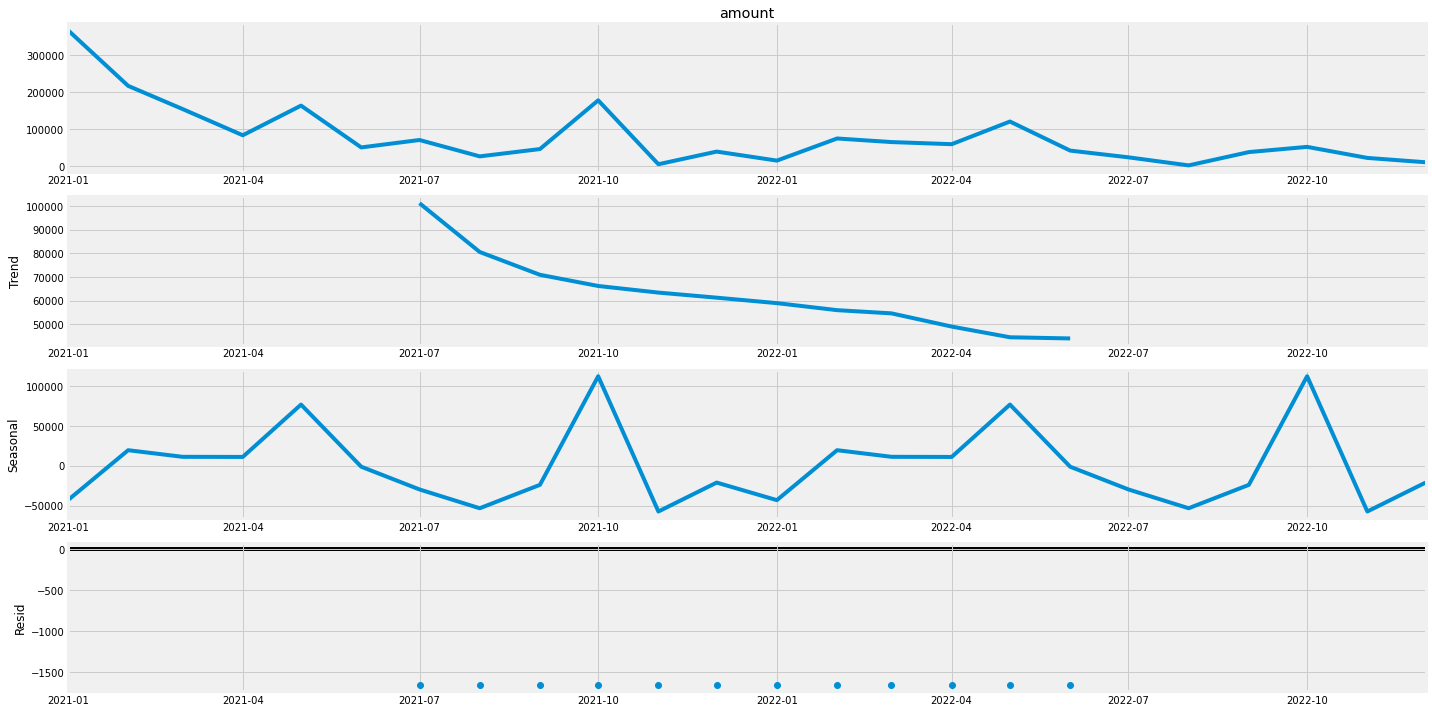

In [40]:
test_df = create_filter_df(syn_dict['870009'], '2021', '2022')
test_df = test_df[test_df.index != '2022-03-11'] # need to replace with mean; not remove for forecast
pos_test = get_pos_only(test_df)
seasonal_decomp_pos(pos_test)

index modified


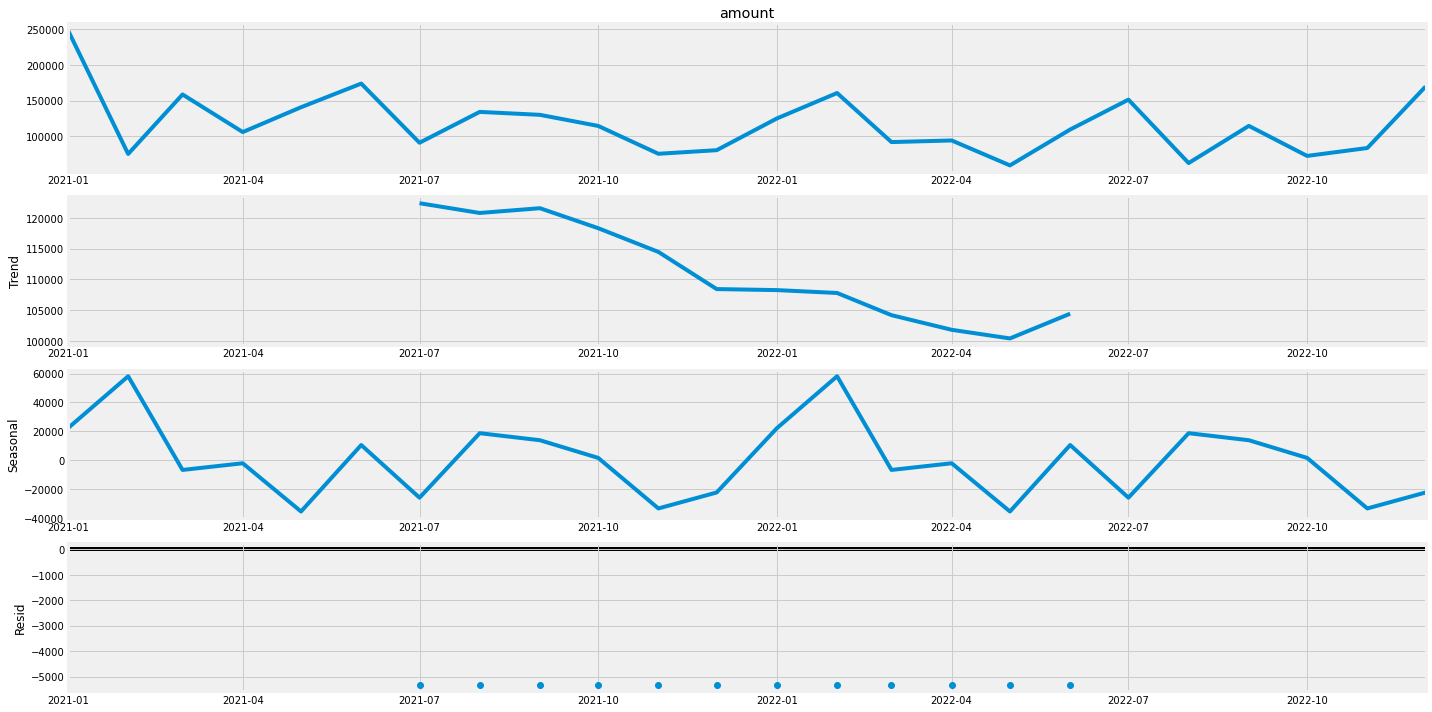

In [41]:
test_df = create_filter_df(syn_dict['870040'], '2021', '2022')
test_df = test_df[test_df.index != '2022-10-14'] # need to replace with mean; not remove for forecast
pos_test = get_pos_only(test_df)
seasonal_decomp_pos(pos_test)

index modified


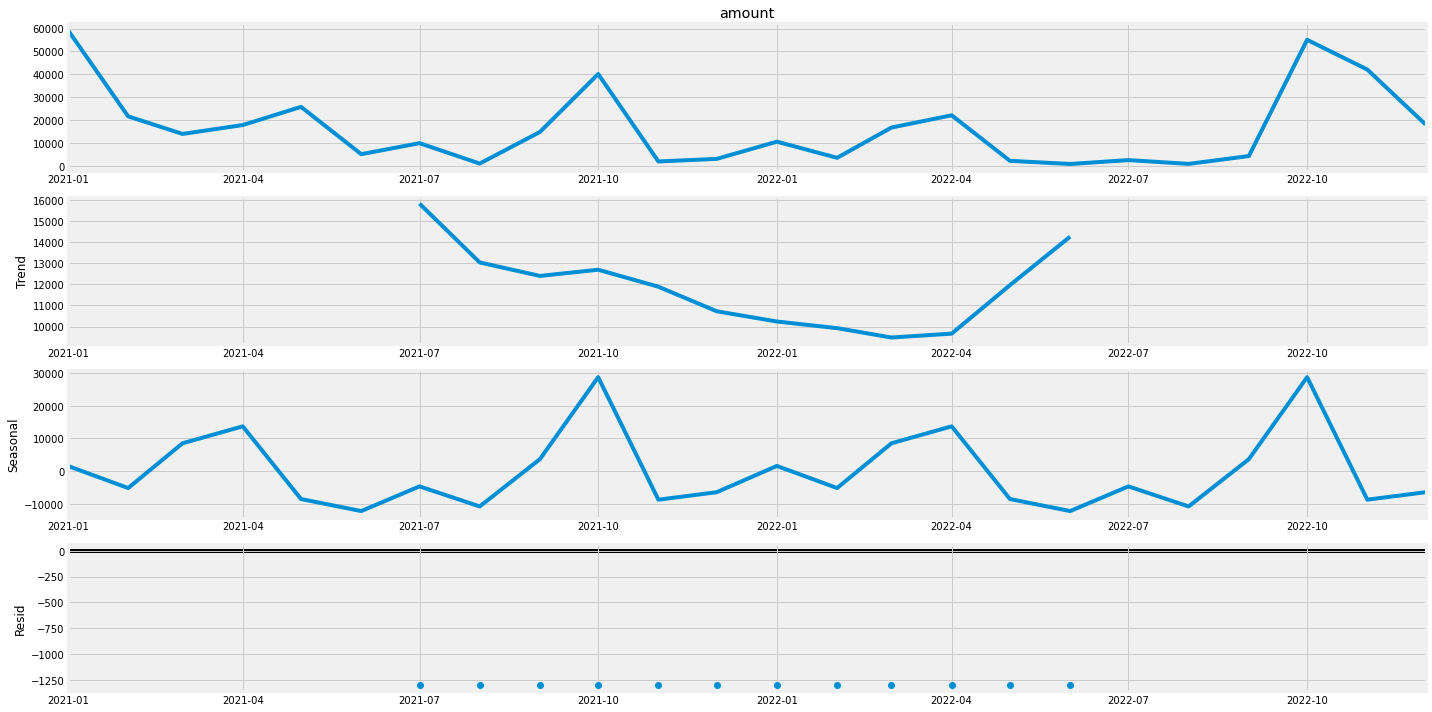

In [42]:
test_df = create_filter_df(syn_dict['870008'], '2021', '2022')
# test_df = test_df[test_df.index != '2022-10-14']
pos_test = get_pos_only(test_df)
seasonal_decomp_pos(pos_test)

In [43]:
df_870008 = syn_dict['870008']['amount']
df_870008.index = df_870008.index.to_timestamp()
df_870008 = df_870008.resample('B').sum()
df_870008 = df_870008.groupby(df_870008.index).sum()

df_870008 = df_870008['2022':'2023']
# pos_df_plt.index = pd.to_datetime(pos_df_plt.index)

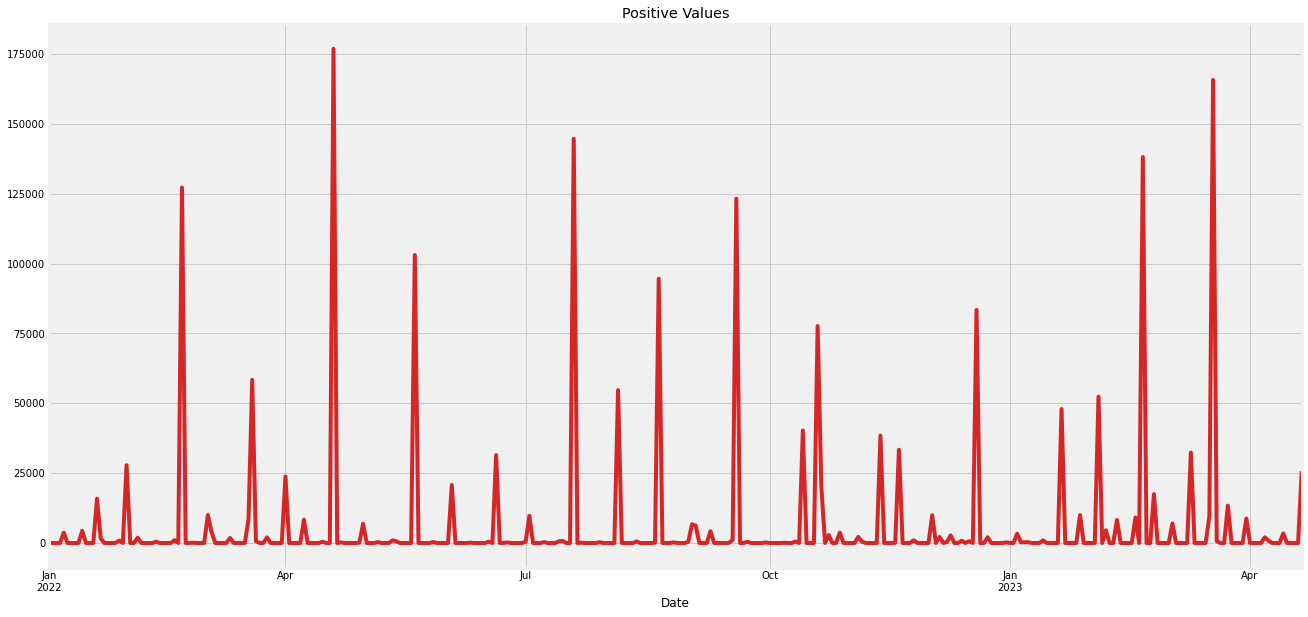

In [44]:
df_870008.plot(color='tab:red')
plt.gca().set(title="Positive Values", xlabel='Date')
plt.show()

## Charts for Justin/Logistics

In [45]:
df_870040_pvt = syn_dict['870040'].pivot_table(index='fiscal_year', values='amount', aggfunc='sum')

In [46]:
df_870040_pvt.T

fiscal_year,2020001,2020002,2020003,2020004,2020005,2020006,2020007,2020008,2020009,2020010,...,2022007,2022008,2022009,2022010,2022011,2022012,2023001,2023002,2023003,2023004
amount,"698,658.80","543,016.37","445,272.06","530,837.37","543,111.09","708,221.98","365,385.38","437,605.06","373,567.78","421,876.17",...,"1,509,708.57","243,168.46","291,744.82","1,091,596.22","202,752.33","321,102.84","377,659.53","841,718.29","1,710,340.66","357,615.72"


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 337870 entries, 2020-03-20 to 2022-09-20
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   sap_post_year      337870 non-null  int16  
 1   fiscal_year        337870 non-null  int32  
 2   bus_area           337870 non-null  object 
 3   company_code       337870 non-null  object 
 4   cost_center        337870 non-null  object 
 5   cost_center_name   337870 non-null  object 
 6   cost_element       337870 non-null  object 
 7   cost_element_name  337870 non-null  object 
 8   amount             337870 non-null  float64
 9   doc_type           337870 non-null  object 
 10  internal_order     337870 non-null  object 
dtypes: float64(1), int16(1), int32(1), object(8)
memory usage: 27.7+ MB


In [48]:
df[(df['cost_element'].str.contains('870040'))&(df['doc_type'].str.contains('SX'))].sort_values(by='fiscal_year')

,sap_post_year,fiscal_year,bus_area,company_code,cost_center,cost_center_name,cost_element,cost_element_name,amount,doc_type,internal_order
post_date,,,,,,,,,,,
2022-04-30,2022,2022004,1111,1100,1220000053,MERCH-BUD LT,870040,TRPT POC MATL,"1,236,491.20",SX,
2022-05-31,2022,2022005,1111,1100,1220000053,MERCH-BUD LT,870040,TRPT POC MATL,"1,118,378.32",SX,
2022-06-30,2022,2022006,1111,1100,1220000053,MERCH-BUD LT,870040,TRPT POC MATL,"245,336.39",SX,
2022-07-31,2022,2022007,1111,1100,1220000053,MERCH-BUD LT,870040,TRPT POC MATL,"92,116.68",SX,
2022-08-31,2022,2022008,1111,1100,1220000053,MERCH-BUD LT,870040,TRPT POC MATL,"106,263.04",SX,
2022-09-30,2022,2022009,1111,1100,1220000053,MERCH-BUD LT,870040,TRPT POC MATL,"195,121.99",SX,
2022-10-31,2022,2022010,1111,1100,1220000053,MERCH-BUD LT,870040,TRPT POC MATL,"150,018.02",SX,
2022-11-30,2022,2022011,1111,1100,1220000053,MERCH-BUD LT,870040,TRPT POC MATL,"160,226.98",SX,
2022-12-31,2022,2022012,1111,1100,1220000053,MERCH-BUD LT,870040,TRPT POC MATL,"109,753.73",SX,


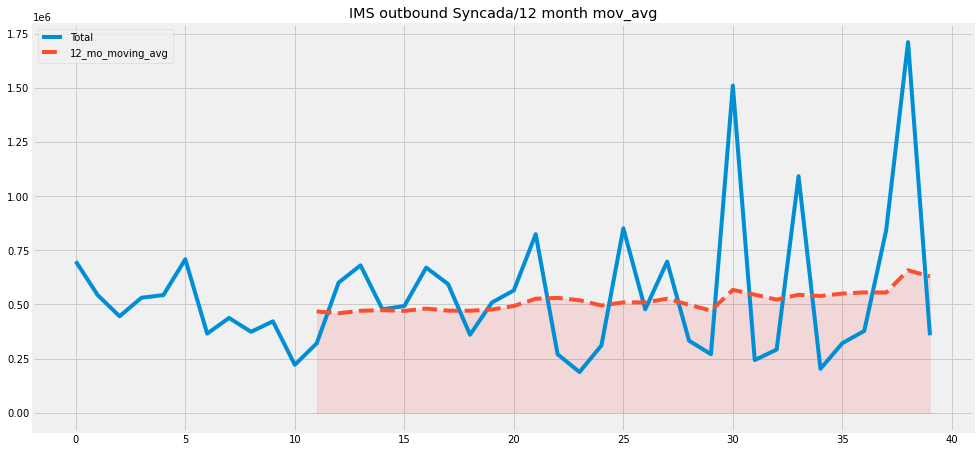

In [49]:
df2 = df_870040_pvt.reset_index()
df2_ma = df2['amount'].rolling(window=12).mean()
fig, ax = plt.subplots(figsize=(15,7.5))

df2.plot(y='amount', label='Total', title='IMS outbound Syncada/12 month mov_avg', ax=ax)
df2_ma.plot(ls='--', label='rolling', ax=ax)
# test.plot(label='y_train', ax=ax)
plt.fill_between(df2_ma.index, 0, df2_ma, color='r', alpha=0.1)
ax.legend(['Total', '12_mo_moving_avg'])
plt.show()

In [50]:
df_870040_pvt

,amount
fiscal_year,
2020001,"698,658.80"
2020002,"543,016.37"
2020003,"445,272.06"
2020004,"530,837.37"
2020005,"543,111.09"
2020006,"708,221.98"
2020007,"365,385.38"
2020008,"437,605.06"
2020009,"373,567.78"


## Do ML work (XGBOOST); no trend needed

In [51]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [52]:
 # Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

In [53]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

In [54]:
df_dict = pd.read_pickle(r'C:\Users\Y893263\POCM_python\syn_dict.pickle')

In [55]:
# df_870008 = df_dict['870008']['amount']
# # df_870008.index = df_870008.index.to_timestamp()
# df_870008 = df_870008.resample('B').sum().to_frame()
# # df_870008 = df_870008.groupby(df_870008.index).sum()

# df_870008 = df_870008['2021':'2022']

# def anch_walk_forward_op_datasets(): # params: df, beg_split_date, end_split_date, num_of_splits
#     # Checks: 
#     #   check if index is datetime; if not convert??
    
#     split_dates = ['2022-07-01', '2022-08-01', '2022-09-01','2022-10-01','2022-11-01', '2022-12-01']
#     # split_date = '2022-07-01'
#     for i in split_dates:
#         idx_train, idx_test = df_870008.index < i, df_870008.index >=i
    
#         X_train, X_test = df_870008.loc[idx_train].to_frame(), df_870008.loc[idx_test].to_frame()
#         y_train, y_test = df_870008.loc[idx_train], df_870008.loc[idx_test]
#         print(f"split_date: {i}")
#         yield X_train, X_test, y_train, y_test

In [56]:
def anch_walk_forward_op_datasets(df, start_date='2022-07-01', end_date='2022-12-31', freq='MS'):
    # Checks: 
    #   check if index is datetime; if not convert??
    split_dates = [y.strftime('%Y-%m-%d') for y in pd.date_range(start=start_date, end=end_date, freq=freq)]
   
    for i in split_dates:
        idx_train, idx_test = df.index < i, df.index >=i
        if not isinstance(df, pd.DataFrame):
            X_train, X_test = df.loc[idx_train].to_frame(), df.loc[idx_test].to_frame()
            y_train, y_test = df.loc[idx_train], df.loc[idx_test]
            print(f"split_date: {i}")
            yield X_train, X_test, y_train, y_test
            
        else: 
            X_train, X_test = df.loc[idx_train], df.loc[idx_test]
            y_train, y_test = df.loc[idx_train], df.loc[idx_test]
            print(f"split_date: {i}")
            yield X_train, X_test, y_train, y_test

In [57]:
def non_anch_walk_forward_op_datasets(df, start_date='2022-07-01', end_date='2022-12-31', freq='MS'):
    # Checks: 
    #   check if index is datetime; if not convert??
    split_dates = [y.strftime('%Y-%m-%d') for y in pd.date_range(start=start_date, end=end_date, freq=freq)]
   
    for i in split_dates:
        idx_train, idx_test = df.index < i, df.index >=i
        if not isinstance(df, pd.DataFrame):
            X_train, X_test = df.loc[idx_train].to_frame(), df.loc[idx_test].to_frame()
            y_train, y_test = df.loc[idx_train], df.loc[idx_test]
            print(f"split_date: {i}")
            yield X_train, X_test, y_train, y_test
            
        else: 
            X_train, X_test = df.loc[idx_train], df.loc[idx_test]
            y_train, y_test = df.loc[idx_train], df.loc[idx_test]
            print(f"split_date: {i}")
            yield X_train, X_test, y_train, y_test

In [58]:
# set this up to accept an algo of choice???
def run_algo(df):
    metrics = []
    df = df
    for X_train, X_test, y_train, y_test in anch_walk_forward_op_datasets(df):
        xgb = xgboost.XGBRegressor()
        xgb.fit(X_train, y_train)
        y_fit = pd.DataFrame(xgb.predict(X_train), index=y_train.index, )
        y_pred = pd.DataFrame(xgb.predict(X_test), index=y_test.index, )
        print(f"shapes: {X_train.shape, X_test.shape, y_train.shape, y_test.shape}")
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        print(f"rmse: {rmse}")
        metrics.append(rmse)
        
        # Plot
        axs = y_train.plot(color='0.25', subplots=True, sharex=True)
        axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
        axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
        axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
        for ax in axs: ax.legend([])
        _ = plt.suptitle("Trends")
        plt.show()
    return sum(metrics) / len(metrics), y_pred.sum(), X_test.sum()

In [59]:
# def plot_algo():
#     for y_train, y_test, y_fit, y_pred in run_algo():
#     # Plot
#         axs = y_train.plot(color='0.25', subplots=True, sharex=True)
#         axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
#         axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
#         axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
#         for ax in axs: ax.legend([])
#         _ = plt.suptitle("Trends")
#         plt.show()

split_date: 2022-07-01
shapes: ((129, 1), (211, 1), (129,), (211,))
rmse: 2835.9317902819685


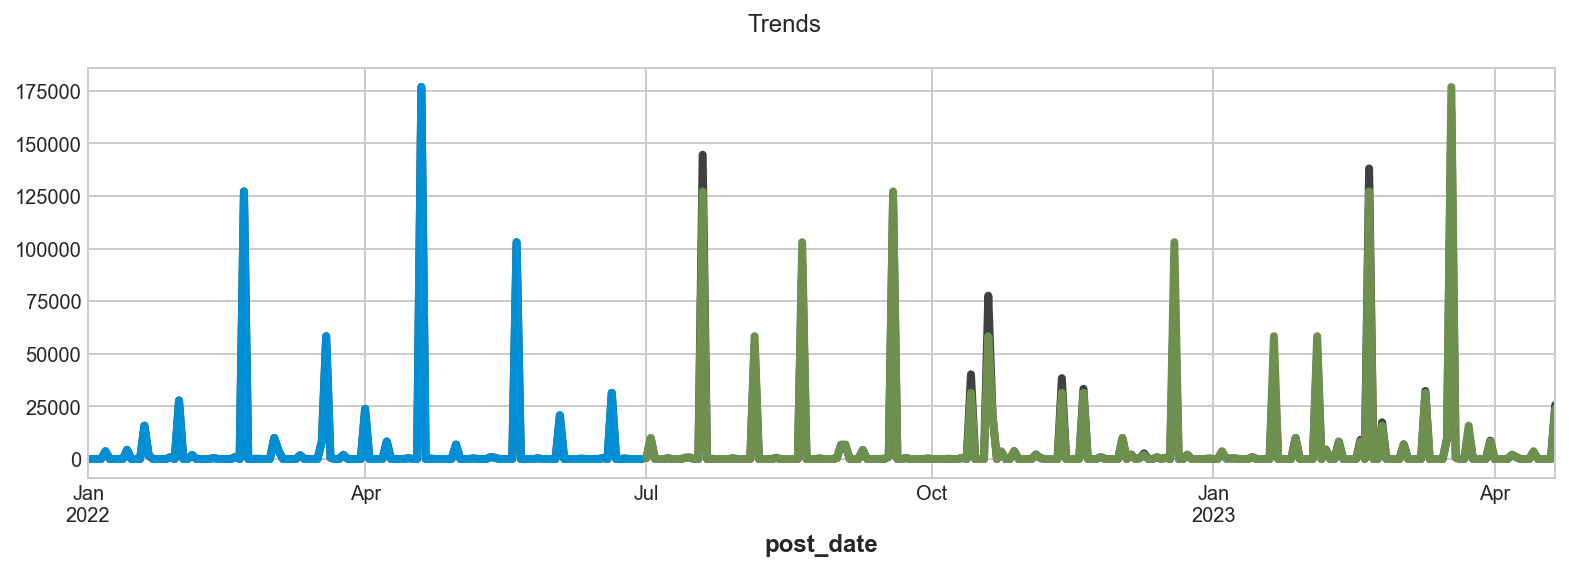

split_date: 2022-08-01
shapes: ((150, 1), (190, 1), (150,), (190,))
rmse: 2631.0458959202465


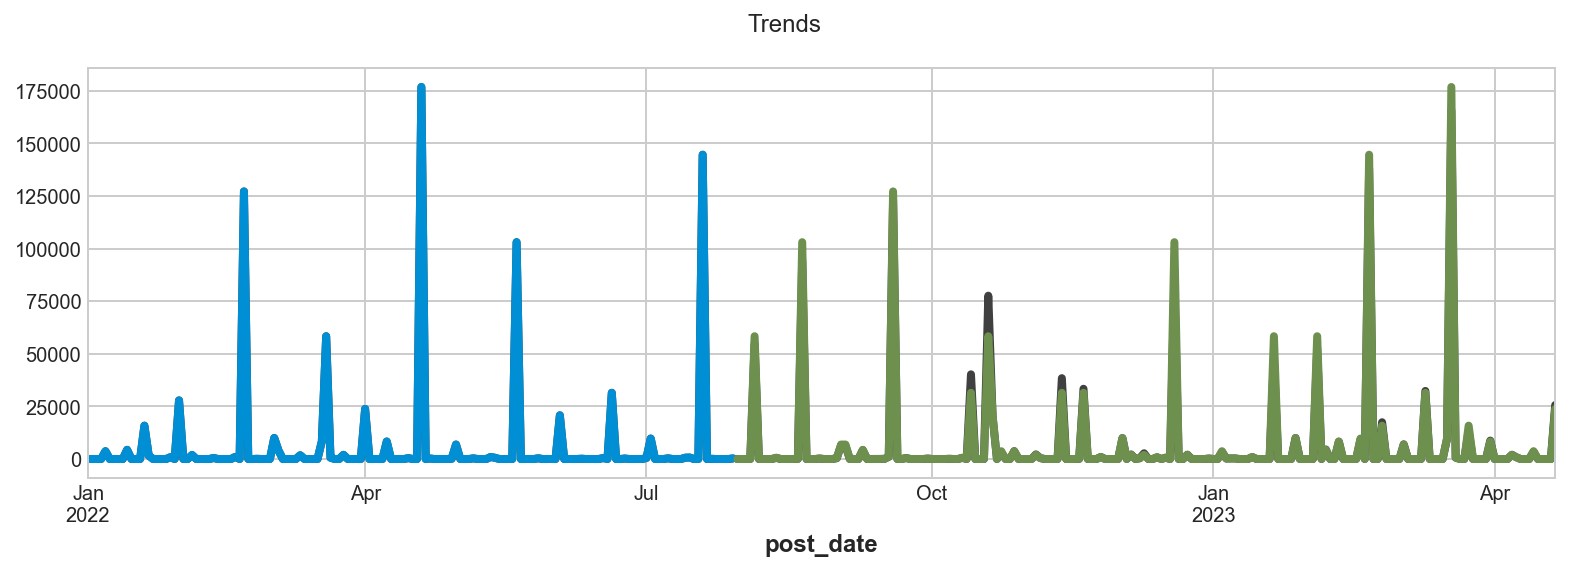

split_date: 2022-09-01
shapes: ((173, 1), (167, 1), (173,), (167,))
rmse: 2175.7951869627846


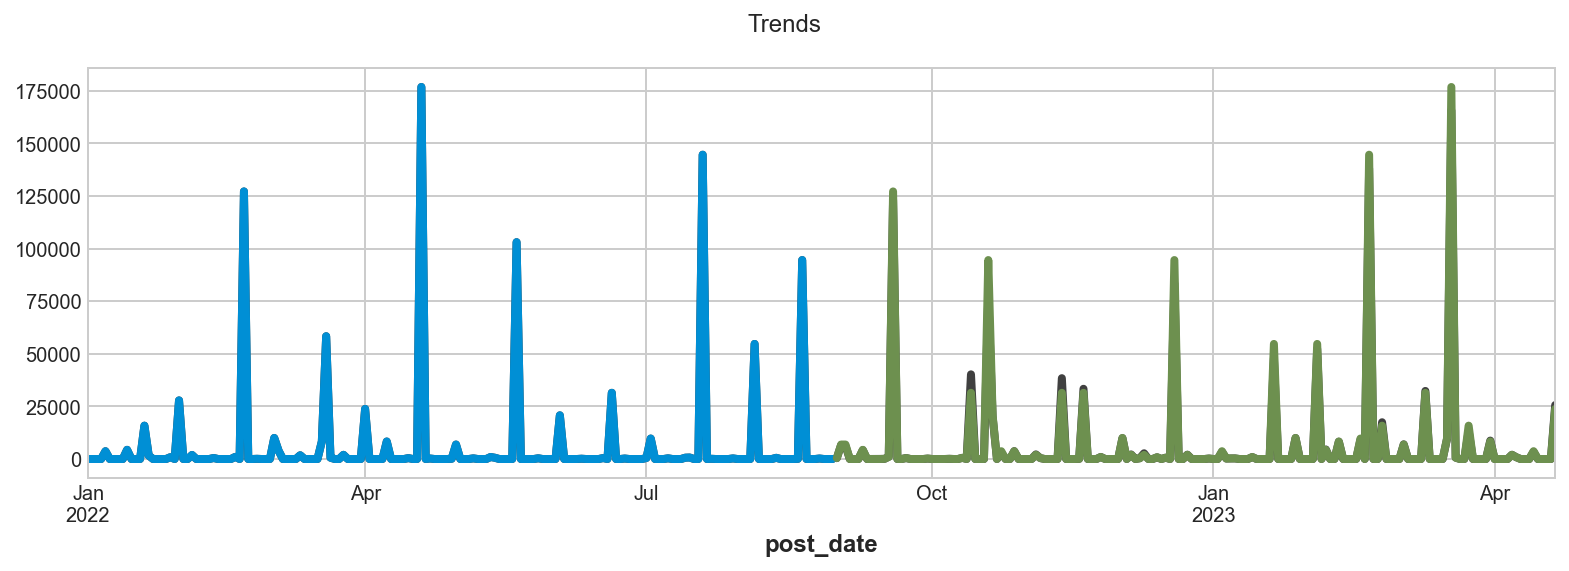

split_date: 2022-10-01
shapes: ((195, 1), (145, 1), (195,), (145,))
rmse: 2310.8410723243974


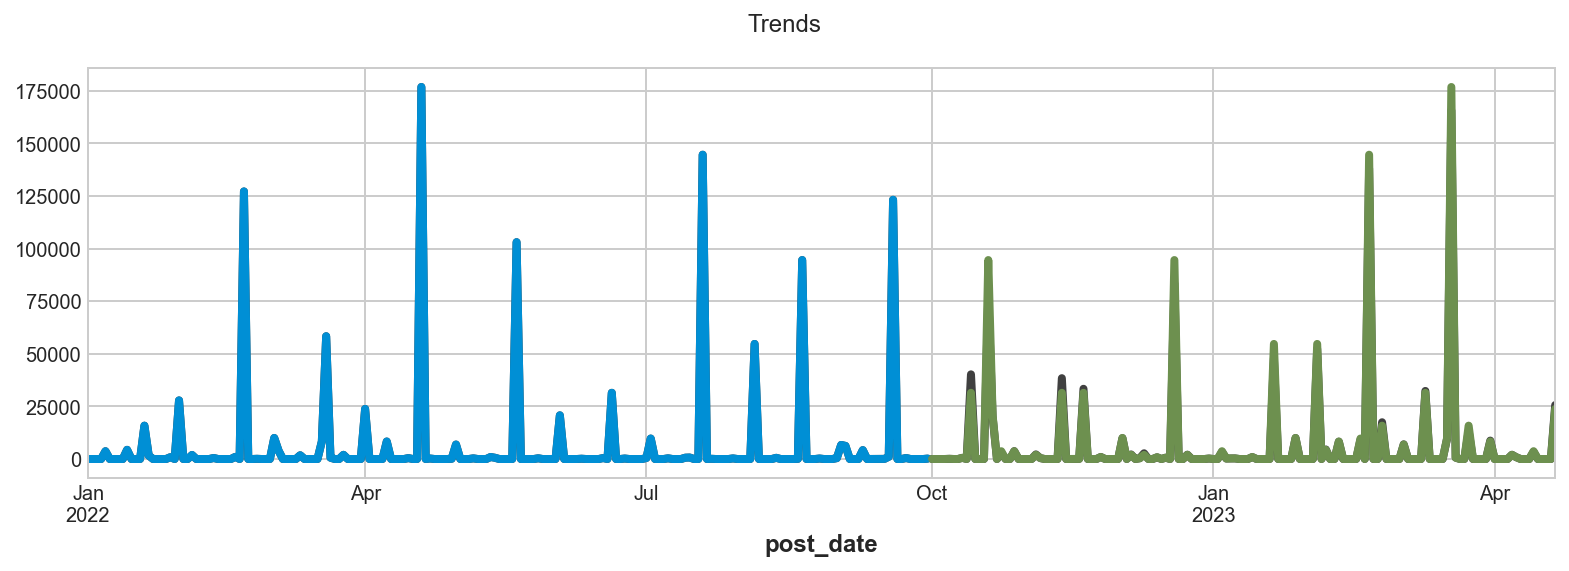

split_date: 2022-11-01
shapes: ((216, 1), (124, 1), (216,), (124,))
rmse: 1482.889809305828


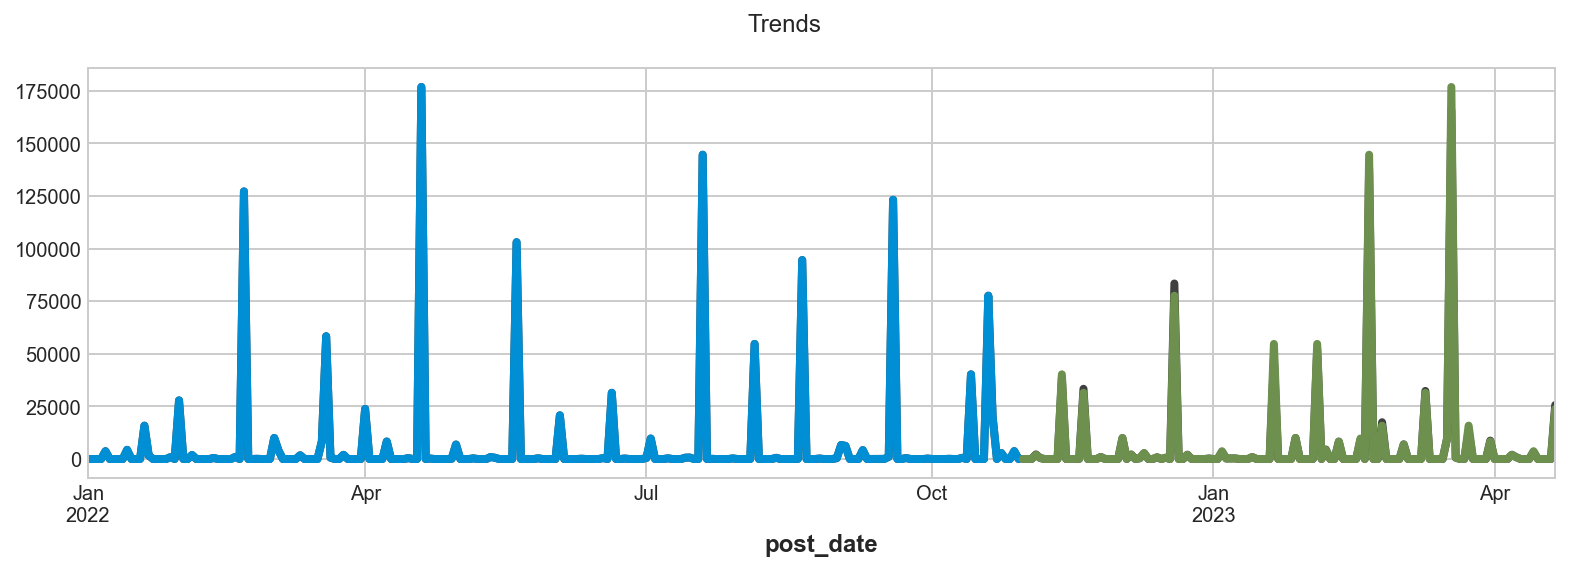

split_date: 2022-12-01
shapes: ((238, 1), (102, 1), (238,), (102,))
rmse: 1613.6023870896197


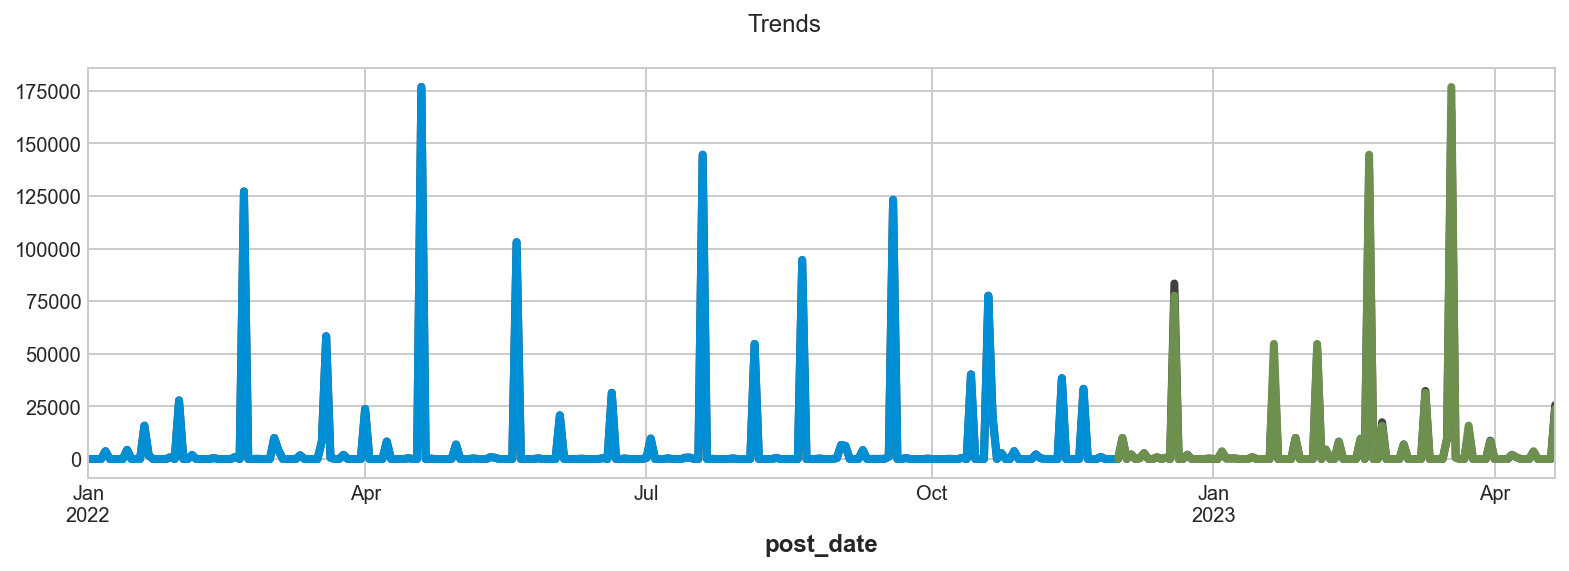

(2175.0176903141414,
 0   684,622.62
 dtype: float32,
 amount   664,424.42
 dtype: float64)

In [60]:
run_algo(df_870008 )

In [61]:
xgb = xgboost.XGBRegressor()

In [62]:
xgb.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [ ]:
y_fit = pd.DataFrame(xgb.predict(X_train), index=y_train.index, )
y_pred = pd.DataFrame(xgb.predict(X_test), index=y_test.index, )

In [ ]:
# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [ ]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(rmse)

In [ ]:
pd.concat([y_test, y_pred], axis=1).head()

## Decision Tree for baseline comparison

In [ ]:
dtr = DecisionTreeRegressor()

In [ ]:
dtr.fit(X_train, y_train)

In [ ]:
y_fit = pd.DataFrame(dtr.predict(X_train), index=y_train.index)
y_pred = pd.DataFrame(dtr.predict(X_test), index=y_test.index)

In [ ]:
# Plot
axs= y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [ ]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(rmse)

## Walk forward optimization

1. Lee's recommendation: Predict every 

N_f - number of freight variables
N_f, days in month

shape(N_f, 1 day) = f(
number of days in the future from our current data point, day of week, month of year,is this a holiday?,
last month's average, last 10 weeks average freight as a series, ....) featurized our feature data

Need to know ratio of train to prediction data

days in month are essentially treated as sample in a minibatch, slightly different features. 

Try to predict days of next month in total

In [ ]:
def get_stats(df, month: int, value=None, group_col=None, freq='M'):
    r = df.resample('M')
    avg_monthly_data_pts = r.count().values.mean()
    avg_last_3_months = r.sum()[-3:].values.mean()
    specific_mon_df = df[df.index.month == month]
    specific_r = specific_mon_df.resample('M')
    specific_mon_avg = specific_r.sum().values.mean()
    
    
    

In [ ]:
df.head()

In [ ]:
# Lee's rec

def freight_forecast(num_future_days, weekday, month, holiday=False, previous_month_avg_freight, prev_10_weeks_avg_freight):
    weekday = get_weekday
    month = get_month
    
def monthly_forecast(num_future_days, month: str, previous_month_avg_freight, prev_10_weeks_avg_freight):
    num_business_day = np.busday_count(month, 
    

In [ ]:
import calendar
year = 2023
month = 4
b_m, e_m = calendar.monthrange(year, month)
print(b_m, e_m)

In [ ]:
calendar.monthrange(year, month)

N_f - number of freight variables
N_f, days in month

 

N_f, 1 day = f(
    number of days in the future from the current datapoint, day of week, month of year, is this a holiday
    last months average freight, last 10 weeks average freight as a series, ...
)

 

days in the month are essentially treated as samples in a minibatch, slightly different features.

In [ ]:
# next_step(df, "2023-01-01", "2023-01-31") 

In [ ]:
print(df.tail(2))
for i in range(33):
    df.index = df.index + pd.DateOffset(days=1)
    print(df.index[-1])
    # df.iloc[df.index[-1], 0] = 1 + i

In [ ]:
 def _recursive_predict(
        self,
        steps: int,
        last_window: np.ndarray,
        exog: Optional[np.ndarray]=None
    ) -> np.ndarray:
        """
        Predict n steps ahead. It is an iterative process in which, each prediction,
        is used as a predictor for the next step.
        
        Parameters
        ----------
        steps : int
            Number of future steps predicted.
            
        last_window : numpy ndarray
            Values of the series used to create the predictors (lags) need in the 
            first iteration of prediction (t + 1).
            
        exog : numpy ndarray, default `None`
            Exogenous variable/s included as predictor/s.
        Returns 
        -------
        predictions : numpy ndarray
            Predicted values.
        
        """

        predictions = np.full(shape=steps, fill_value=np.nan)

        for i in range(steps):
            X = last_window[-self.lags].reshape(1, -1)
            if exog is not None:
                X = np.column_stack((X, exog[i, ].reshape(1, -1)))

            with warnings.catch_warnings():
                # Suppress scikit-learn warning: "X does not have valid feature names,
                # but NoOpTransformer was fitted with feature names".
                warnings.simplefilter("ignore")
                prediction = self.regressor.predict(X)
                predictions[i] = prediction.ravel()[0]

            # Update `last_window` values. The first position is discarded and 
            # the new prediction is added at the end.
            last_window = np.append(last_window[1:], prediction)

        return predictions

In [ ]:
np.full(shape=6, fill_value=np.nan)

In [ ]:
test_df = create_filter_df(syn_dict['870008'], '2021', '2022')

In [ ]:
test_df.columns

In [ ]:
test_df

In [ ]:
test_df.columns = test_df.columns.get_level_values(0)

In [ ]:
test_df

In [ ]:
test_df.columns

In [ ]:
for i in syn_dict.keys():
    print(f"CE: {i}")
    test_df = create_filter_df(syn_dict[i], '2022-01', '2022-12')
    pos_test = get_pos_only(test_df)
    return_corr_and_totals(test_df)
    print('\n')

In [ ]:
syn_ib = syn_dict['870008']
syn_ib = syn_ib[['amount']].sort_index()

In [ ]:
syn_ib.index = syn_ib.index.to_period('D')

In [ ]:
syn_ib_pos = syn_ib[syn_ib['amount'] >= 0]
syn_ib_neg = syn_ib[syn_ib['amount'] < 0]
neg_pv = syn_ib_neg.pivot_table(index=syn_ib_neg.index, values='amount', aggfunc='sum').reset_index().set_index('post_date')
pos_pv = syn_ib_pos.pivot_table(index=syn_ib_pos.index, values='amount', aggfunc='sum').reset_index().set_index('post_date')

In [ ]:
syn_2022 = pd.concat([pos_pv["2021":"2022"], neg_pv["2021":"2022"]], axis=1, keys=['pos', 'neg'], names=['pos_amount', 'neg_amount']).fillna(0)

In [ ]:
syn_2022[syn_2022['neg']['amount'] !=0].corr()

__Looks like good correlation__

In [ ]:
syn_2022[syn_2022['neg']['amount'] == 0].sum()

In [ ]:
syn_2022[syn_2022['neg']['amount'] != 0].sum()

In [ ]:
syn_2022['pos'].plot()

In [ ]:
syn_2022['neg'].plot()

In [ ]:
sns.heatmap(df.corr(), annot=True)

In [ ]:
df

In [ ]:
df_inbound = df[['Product total', 'Syncada IB']]

In [ ]:
df_inbound

In [ ]:
for i in range(7):
    df_inbound[f'IB shift{-i}'] = df_inbound['Syncada IB'].shift(-i, fill_value=0)

In [ ]:
df_inbound

In [ ]:
for i in range(7):
    df_inbound[f'IB shift pos{i}'] = df_inbound['Syncada IB'].shift(i, fill_value=0)

In [ ]:
df_inbound

In [ ]:
mask = np.triu(df_inbound.corr())
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df_inbound.corr(), annot=True, mask=mask)

In [ ]:
def smoothing(numbers: list, stop: int):
    import statistics
    new_vals_3_mean = []
    new_vals_2_mean = []
    for idx, val in enumerate(numbers):
        if idx > stop:
            break
        new_vals_3_mean.append(statistics.mean([numbers[idx], numbers[idx+1], numbers[idx+2]]))
        new_vals_2_mean.append(statistics.mean([numbers[idx], numbers[idx+1]]))
    return new_vals_2_mean, new_vals_3_mean
    
def fix_smooth_total(numbers: list):
    return [i + (1 -sum(numbers))/len(numbers) for i in numbers]

In [ ]:
ib_list = df_inbound.loc[3:, 'IB shift pos3'].to_list()
ib_list = [round(x) for x in ib_list]
ib_list2, ib_list3 = smoothing(ib_list, len(ib_list)-3)
df_weight_ib = pd.DataFrame({'Product Total': [x for x in df.iloc[3:7, 0]],
                            'ib_list2': ib_list2,
                            'ib_list3': ib_list3})

In [ ]:
df_weight_ib

In [ ]:
mask = np.triu(df_weight_ib.corr())
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(df_weight_ib.corr(), annot=True, mask=mask)

In [ ]:
df.columns

In [ ]:
df_ob = df[['Product total','Syncada OB', 'Syncada Drop','Combined_ob']]
df_ob_mod = df_mod[['Product total','Syncada OB', 'Syncada Drop','Combined_ob']]

In [ ]:
df_ob

In [ ]:
def pos_shift(num: int, df, col_name:str, new_col_name: str):
    for i in range(num):
        df[f'{new_col_name}_{i}'] = df[col_name].shift(i, fill_value=0)
        
def neg_shift(num: int, df, col_name:str, new_col_name: str):
    for i in range(num):
        df[f'{new_col_name}_{-i}'] = df[col_name].shift(-i, fill_value=0)

In [ ]:
shift_cols = df_ob.columns[1:4]
for i in range(len(shift_cols)):
    pos_shift(7, df_ob, shift_cols[i], shift_cols[i])

In [ ]:
df_ob

In [ ]:
df_ob.columns

In [ ]:
mask = np.triu(df_ob.corr())
fig, ax = plt.subplots(figsize=(30,15))
sns.heatmap(df_ob.corr(), annot=True, mask=mask)

In [ ]:
corr_order = np.argsort(-df_ob.corr().values, axis=1)[0]

In [ ]:
corr_order

In [ ]:
filt_index = df_ob.corr().columns[corr_order]

In [ ]:
results = pd.DataFrame(
    {'Sales corr': df_ob.corr().columns[corr_order],
     'values': [round(df_ob.corr().loc[i, 'Product total'], 2) for i in filt_index]},
    index=corr_order
)

In [ ]:
results.head(10)

In [ ]:
cols_needed = [i for i in results['Sales corr'][:10]]

In [ ]:
df_ob[cols_needed]

In [ ]:
shift_cols2 = df_ob_mod.columns[1:4]
for i in range(len(shift_cols2)):
    pos_shift(7, df_ob_mod, shift_cols2[i], shift_cols2[i])

In [ ]:
mask = np.triu(df_ob_mod.corr())
fig, ax = plt.subplots(figsize=(30,15))
sns.heatmap(df_ob_mod.corr(), annot=True, mask=mask)

In [ ]:
corr_order2 = np.argsort(-df_ob_mod.corr().values, axis=1)[0]

In [ ]:
filt_index2 = df_ob_mod.corr().columns[corr_order2]

In [ ]:
results2 = pd.DataFrame(
    {'Sales corr': df_ob_mod.corr().columns[corr_order2],
     'values': [round(df_ob_mod.corr().loc[i, 'Product total'], 2) for i in filt_index2]},
    index=corr_order2
)

In [ ]:
results2.head(10)

In [ ]:
cols_needed2 = [i for i in results2['Sales corr'][:10]]

In [ ]:
ob_shift_df = df_ob_mod[cols_needed2]

In [ ]:
ob_shift_df

In [ ]:
df_ob_smooth = ob_shift_df.iloc[3:9, :3]

In [ ]:
df_ob_smooth

## Do this tomorrow

In [ ]:
ob_list_1 = df_ob_smooth['Combined_ob_3'].to_list()
ob_list_1 = [round(x) for x in ob_list_1]

ob_list2, ob_list3 = smoothing(ob_list_1, len(ob_list_1)-3)


df_weight_ob = pd.DataFrame({'Product Total': [x for x in df.iloc[3:7, 0]],
                            'ob_list2': ob_list2,
                            'ob_list3': ob_list3})

In [ ]:
df_weight_ob

In [ ]:
ob_list_1 = df_ob_smooth['Syncada OB_3'].to_list()
ob_list_1 = [round(x) for x in ob_list_1]

ob_list2, ob_list3 = smoothing(ob_list_1, len(ob_list_1)-3)


df_weight_ob = pd.DataFrame({'Product Total': [x for x in df.iloc[3:7, 0]],
                            'ob_list2': ob_list2,
                            'ob_list3': ob_list3})

In [ ]:
df_weight_ob